In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None, label = "None", marker_size = 2):
    plt.grid(True)
    plt.plot(x, y, "o", markersize = marker_size)
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = DData(x.min()).value
    if(xmax == None):
        xmax = DData(x.max()).value
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value, label = label)
    print("k, b =", k, b)
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:201: SyntaxWarning: invalid escape sequence '\p'
<>:204: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\c'
<>:209: SyntaxWarning: invalid escape sequence '\p'
<>:201: SyntaxWarning: invalid escape sequence '\p'
<>:204: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\c'
<>:209: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_24356\253664769.py:201: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_24356\253664769.py:204: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_24356\253664769.py:206: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E

In [68]:
V = DData(775,10,E=-6)
LS = DData(5.5,0.5,E=2)
c_del = DData(747.8/100.5, epsilon=0.01)

k, b = $-0.00296918 \pm 0.00000021$ $3.140366 \pm 0.000034$
k, b = $-0.00143387 \pm 0.00000097$ $2.97899 \pm 0.00028$
k, b = $-0.00101380 \pm 0.00000047$ $2.81726 \pm 0.00018$
k, b = $-0.00057345 \pm 0.00000016$ $2.828196 \pm 0.000090$


,P_,P,data,k,tao,D
0,5.5,$5.443 \pm 0.054$,t (s) V (mV) 0 0.000 23.1252 1 ...,$-0.00296918 \pm 0.00000021$,$336.793 \pm 0.023$,$12.7 \pm 1.2$
1,11.0,$10.89 \pm 0.11$,t (s) V (mV) 0 0.000 19.8414 1 ...,$-0.00143387 \pm 0.00000097$,$697.41 \pm 0.47$,$6.11 \pm 0.56$
2,16.0,$15.83 \pm 0.16$,t (s) V (mV) 0 0.000 16.8779 1 ...,$-0.00101380 \pm 0.00000047$,$986.38 \pm 0.46$,$4.32 \pm 0.40$
3,28.0,$27.71 \pm 0.28$,t (s) V (mV) 0 0.000 17.0359 1 ...,$-0.00057345 \pm 0.00000016$,$1743.82 \pm 0.49$,$2.44 \pm 0.22$


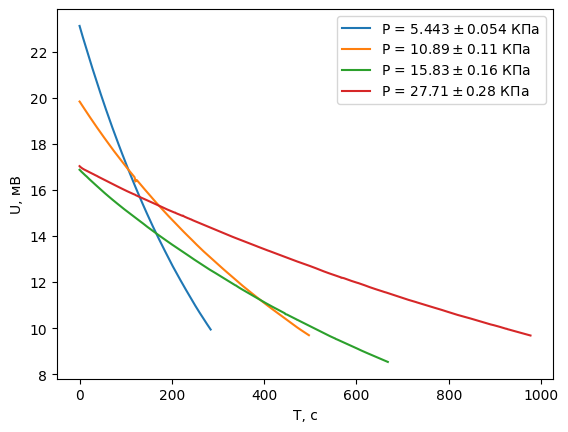

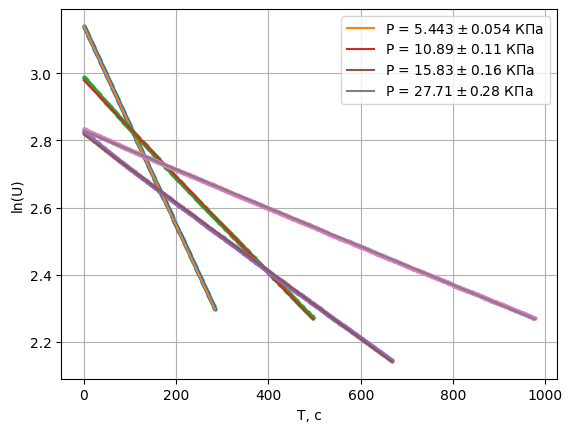

In [69]:
stupid_table = pd.DataFrame()

c_del = DData(747.8/100.5, epsilon=0.01)

stupid_table["P_"] = [5.5,11,16,28]
stupid_table["P"] = stupid_table["P_"] * c_del * 133
DData.changeEInSerias(stupid_table["P"], 3)
stupid_table["data"] = [pd.read_csv("data/20240409_1712648005514_41.2.csv"),
                         pd.read_csv("data/20240409_1712649724639_81.8.csv"),
                         pd.read_csv("data/20240409_1712651349630_119.csv"),
                         pd.read_csv("data/20240409_1712653286041_206.8.csv")]
for i in range(len(stupid_table)):
    plt.xlabel("T, с")
    plt.ylabel("U, мВ")
    ts = stupid_table["data"][i]["t (s)"]
    vs = stupid_table["data"][i]["V (mV)"]
    plt.plot(ts, vs, label=f"P = {stupid_table['P'][i]} КПа")
    plt.legend()
    #linearcalc(ts, vs)
plt.savefig("non_log.png", dpi = 300)
plt.figure()

ks = []
for i in range(len(stupid_table)):
    plt.xlabel("T, с")
    plt.ylabel("ln(U)")
    ts = stupid_table["data"][i]["t (s)"]
    vs = stupid_table["data"][i]["V (mV)"]
    k, _ = linearcalc(ts, np.log(vs), label=f"P = {stupid_table['P'][i]} КПа")
    plt.legend()
    ks.append(k)
plt.savefig("log.png", dpi = 300)
stupid_table["k"] = ks
stupid_table["tao"] = -1/stupid_table["k"]
stupid_table["D"] = LS*V/stupid_table["tao"]
DData.changeEInSerias(stupid_table["D"], -4)
stupid_table

[-0.00737242  0.20109658]
k, b = $69.2 \pm 1.1$ $-0.10 \pm 0.12$
$0.59 \pm 0.12$ 0.1953520411811865
V= 1587.8980891719746
$9.68 \pm 0.90$ 0.09245015310879762


,P_,P,data,k,tao,D,lamb,sigma
0,5.5,$5.443 \pm 0.054$,t (s) V (mV) 0 0.000 23.1252 1 ...,$-0.00296918 \pm 0.00000021$,$336.793 \pm 0.023$,$12.7 \pm 1.2$,$797 \pm 73$,$9.54 \pm 0.88$
1,11.0,$10.89 \pm 0.11$,t (s) V (mV) 0 0.000 19.8414 1 ...,$-0.00143387 \pm 0.00000097$,$697.41 \pm 0.47$,$6.11 \pm 0.56$,$385 \pm 35$,$9.88 \pm 0.91$
2,16.0,$15.83 \pm 0.16$,t (s) V (mV) 0 0.000 16.8779 1 ...,$-0.00101380 \pm 0.00000047$,$986.38 \pm 0.46$,$4.32 \pm 0.40$,$272 \pm 25$,$9.61 \pm 0.89$
3,28.0,$27.71 \pm 0.28$,t (s) V (mV) 0 0.000 17.0359 1 ...,$-0.00057345 \pm 0.00000016$,$1743.82 \pm 0.49$,$2.44 \pm 0.22$,$154 \pm 14$,$9.71 \pm 0.90$


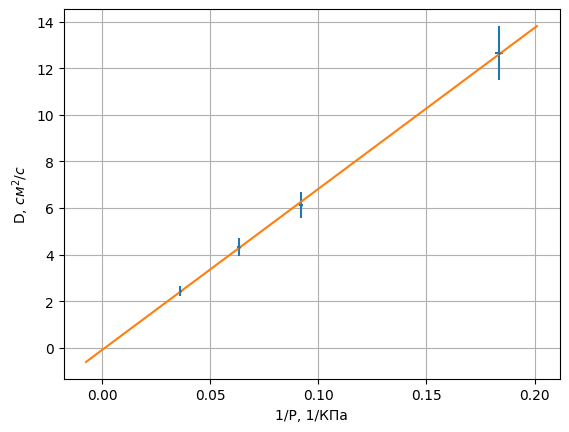

In [77]:
plt.xlabel("1/P, 1/КПа")
plt.ylabel("D, $см^2/с$")

k, b = linearcalc_error(1/stupid_table["P"], stupid_table["D"], xmin=0.01)
plt.savefig("PD.png", dpi=300)
D_atm = b + k*(10**-2)
print(D_atm, D_atm.epsilon)
V = (8*8.31*300/3.14/4)
print("V=", V)
stupid_table["lamb"] = stupid_table["D"]/V
k = DData(1.38, E=-23)
stupid_table["sigma"] = 1/stupid_table["lamb"]*300*k/stupid_table["P"]
DData.changeEInSerias(stupid_table["sigma"], -19)
DData.changeEInSerias(stupid_table["lamb"],-9)
sigma = SerDData(stupid_table["sigma"]).mean
print(sigma, sigma.epsilon)
stupid_table


In [71]:
stupid_table

,P_,P,data,k,tao,D,lamb,sigma
0,5.5,$5.443 \pm 0.054$,t (s) V (mV) 0 0.000 23.1252 1 ...,$-0.00296918 \pm 0.00000021$,$336.793 \pm 0.023$,$12.7 \pm 1.2$,$797 \pm 73$,$9.54 \pm 0.88$
1,11.0,$10.89 \pm 0.11$,t (s) V (mV) 0 0.000 19.8414 1 ...,$-0.00143387 \pm 0.00000097$,$697.41 \pm 0.47$,$6.11 \pm 0.56$,$385 \pm 35$,$9.88 \pm 0.91$
2,16.0,$15.83 \pm 0.16$,t (s) V (mV) 0 0.000 16.8779 1 ...,$-0.00101380 \pm 0.00000047$,$986.38 \pm 0.46$,$4.32 \pm 0.40$,$272 \pm 25$,$9.61 \pm 0.89$
3,28.0,$27.71 \pm 0.28$,t (s) V (mV) 0 0.000 17.0359 1 ...,$-0.00057345 \pm 0.00000016$,$1743.82 \pm 0.49$,$2.44 \pm 0.22$,$154 \pm 14$,$9.71 \pm 0.90$


In [72]:
table_out = pd.DataFrame()
table_out["P, дел"] = stupid_table["P_"]
table_out["P, кПа"] = stupid_table["P"]
table_out["τ, с"] = stupid_table["tao"]
table_out["D, $см^2/с$"] = stupid_table["D"]
table_out["λ, нм"] = stupid_table["lamb"]
table_out["σ, $10^{-19} м^2$"] = stupid_table["sigma"]
table_out.to_clipboard()
table_out

,"P, дел","P, кПа","τ, с","D, $см^2/с$","λ, нм","σ, $10^{-19} м^2$"
0,5.5,$5.443 \pm 0.054$,$336.793 \pm 0.023$,$12.7 \pm 1.2$,$797 \pm 73$,$9.54 \pm 0.88$
1,11.0,$10.89 \pm 0.11$,$697.41 \pm 0.47$,$6.11 \pm 0.56$,$385 \pm 35$,$9.88 \pm 0.91$
2,16.0,$15.83 \pm 0.16$,$986.38 \pm 0.46$,$4.32 \pm 0.40$,$272 \pm 25$,$9.61 \pm 0.89$
3,28.0,$27.71 \pm 0.28$,$1743.82 \pm 0.49$,$2.44 \pm 0.22$,$154 \pm 14$,$9.71 \pm 0.90$
